# Kriging the short dataset

In [7]:
from importlib import reload
try:
    reload(kriging)
    from kriging import Kriging
except:
    import kriging
    reload(kriging)
    from kriging import Kriging
import numpy as np
import matplotlib.pyplot as plt

import time

In [8]:
freqarr, freqstep = np.linspace(0,250,4096,retstep=True) # Based on number of frequency channels of the antenna
# minfreq = 30
# maxfreq = 200
# minfreqarg = int(minfreq/freqstep)
# maxfreqarg = int(maxfreq/freqstep)
print(freqstep)
print(freqarr[2000:2002])
freq = 100 # MHz
freq_index = int(freq/freqstep)
print(freq_index)

0.06105006105006105
[122.1001221  122.16117216]
1638


In [9]:
# Load in the data
year = '2021'
instrument = '100MHz'
channel = 'NS'

datadir = '../test_data/'+year+'/'+instrument+'/'+channel+'/'

save_mask = np.load(datadir+'shortdata_'+year+'_'+instrument+'_'+channel+'_mask.npy')
dat=np.load(datadir+'shortdata_meas_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
lst=np.load(datadir+'shortlst_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t=np.load(datadir+'shortsystime_'+year+'_'+instrument+'_'+channel+'.npy')[save_mask]
t_ant = np.load(datadir+'antsystime_'+year+'_'+instrument+'_'+channel+'.npy')

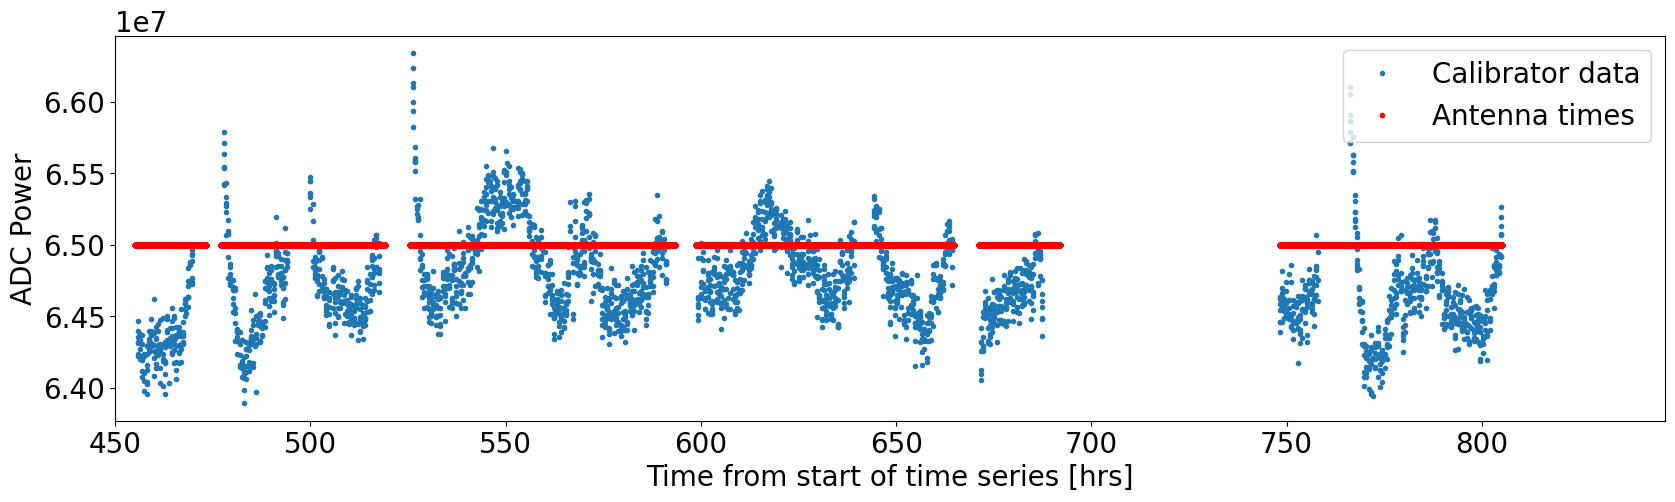

In [10]:
# Optional: select a subset of the data (mostly for testing)
# tmax=1.6374e9
# tmin=1.6365e9
# tmax=1.636e9
tmax=np.inf
tmin=0

mask=(t>tmin)&(t<tmax)
tt=t[mask]
dd=dat[mask,:]

ant_mask = (t_ant>tmin)&(t_ant<tmax)
tt_ant = t_ant[ant_mask]

# Pick a freq_index to plot (the fit is done for all frequencies)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,5))
plt.plot((tt-tt[0])/3600,dd[:,freq_index],'.',label='Calibrator data')
plt.plot((tt_ant-tt[0])/3600,[6.5e7 for ti in tt_ant],'.',color='red',label='Antenna times')
# plt.title('Short Calibrator Data and Antenna Times To Interpolate To\nFrequency Channel = '+str(freq)+'MHz')
# plt.xlim(left=-40,right=60)
plt.xlim(left=450)
plt.xlabel('Time from start of time series [hrs]')
plt.ylabel('ADC Power')
plt.legend(loc='upper right')
# plt.savefig('PreInterp3.png',bbox_inches='tight',dpi=300)
plt.show()

In [11]:
# Step 1: Initialize Kriging class
# You can actually pass tmax and tmin to the Kriging object and it'll select for you
krig_object = Kriging(systime=t,data=dat,interp_times=t_ant,tmax_mask=tmax,tmin_mask=tmin,
                      minfreqarg=2000,maxfreqarg=2001)

In [12]:
# Step 2: Call the object to perform the Kriging
tstart = time.time()
krig_object(dt=5,dtmax=10*3600,acf_functype='quadpeak') # dt and dtmax in seconds
tend = time.time()
print('Time taken:',tend-tstart,'sec')

Verifying freq args are the same within kriging object: min 2000 , max 2001
122.10012210012209 MHz channel done
122.16117216117216 MHz channel done
Time taken: 168.09278774261475 sec


In [13]:
slct = 0
rslt = krig_object.interp_data[slct]
print(rslt)
err = krig_object.interp_std[slct]
avgd_time = krig_object.save_avgd_time[slct]
avgd_data = krig_object.save_avgd_data[slct]
avgd_data_std = krig_object.save_avgd_data_std[slct]

[              nan               nan               nan ...
 60770077.59559736 60770031.58198903 60769982.50402444]


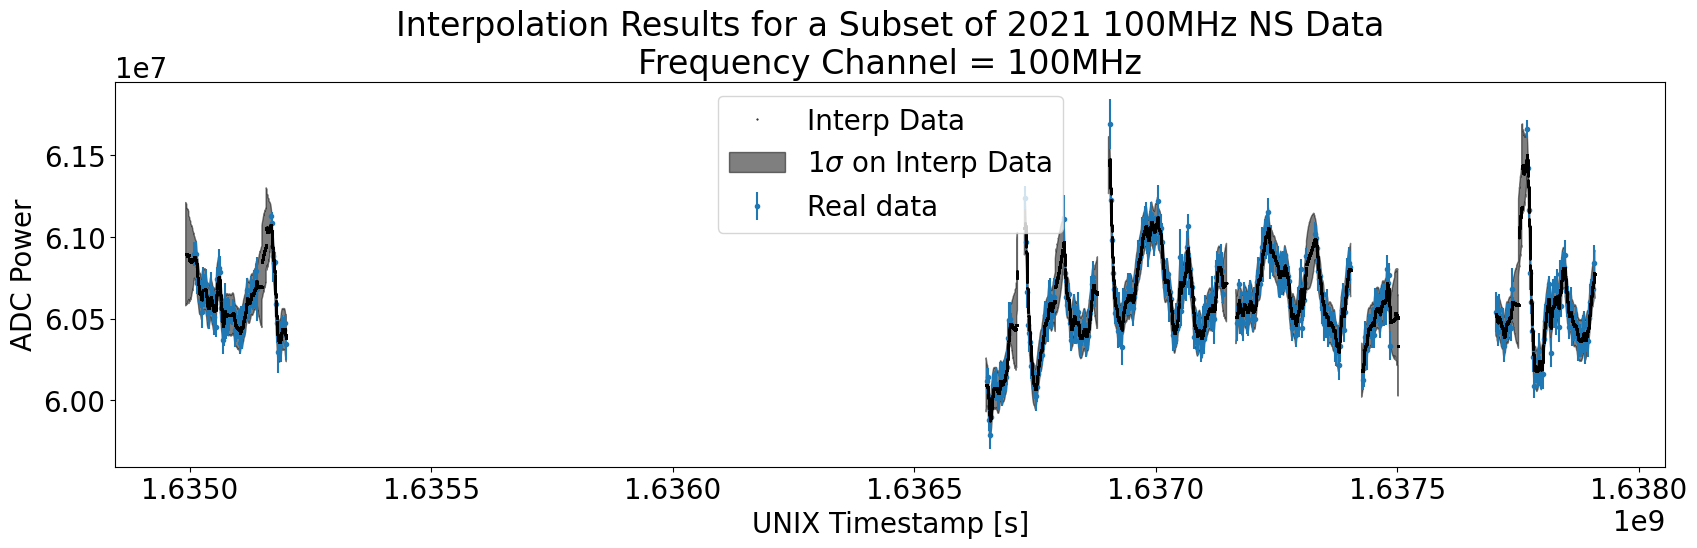

In [22]:
fig = plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 20})

# Select frequency ------
freq = 100 # MHz
freq_index = int(freq/freqstep)
# -----------------------

# Plot the averaged data with error bars
x = tt_ant
y1 = (rslt-err)
y2 = (rslt+err)

gap_threshold = 60*60 # 1h gap threshold
mask = np.ediff1d(x, to_begin=0) > gap_threshold

x_masked = np.ma.masked_where(mask, x)
y1_masked = np.ma.masked_where(mask, y1)
y2_masked = np.ma.masked_where(mask, y2)

plt.errorbar(x=avgd_time,y=avgd_data,yerr=avgd_data_std,marker='.',label='Real data',ls='none',zorder=1)

# Plot the results of the interpolation at antenna times
plt.plot(tt_ant,rslt,'.',ms=1,label='Interp Data',color='k',zorder=2)
plt.fill_between(x_masked,y1_masked,y2_masked,alpha=0.5,color='k',zorder=0,label=r'1$\sigma$ on Interp Data')

# plt.ylim(bottom=7e7)
plt.xlabel('UNIX Timestamp [s]')
plt.ylabel('ADC Power')
plt.legend()
plt.title('Interpolation Results for a Subset of '+year+' '+instrument+' '+channel+' Data\nFrequency Channel = '+str(freq)+'MHz')
# plt.plot(tt_ant,[6.6e7 for ti in tt_ant],'.',color='red',label='Antenna times (interp times)')
# plt.xlim(left= 1.6365e9,right=1.6380e9)
# plt.ylim(top=6.9e7,bottom=6.4e7)
# plt.savefig('InterpRslt',dpi=300)
plt.show()